# QR Decomposition

In [87]:
import numpy as np
from scipy import linalg as la

#### Problem 1

In [88]:
def QR_decomposition(A):
    m, n = A.shape
    Q = np.copy(A)
    R = np.zeros((n, n))
    for i in range(n):
        R[i, i] = la.norm(Q[:, i])
        Q[:, i] = Q[:, i] / R[i, i]
        for j in range(i + 1, n):
            R[i, j] = Q[:, j].T @ Q[:, i]
            Q[:, j] = Q[:, j] - R[i, j] * Q[:, i]
    return Q, R

In [89]:
A = np.random.random((6, 4))
Q, R = la.qr(A, mode='economic')
print(A.shape, Q.shape, Q.T.shape, R.shape)

(6, 4) (6, 4) (4, 6) (4, 4)


In [90]:
np.allclose(np.triu(R), R)

True

In [91]:
np.allclose(Q.T @ Q, np.identity(4))

True

In [92]:
np.allclose(Q @ R, A)

True

In [93]:
Q, R = QR_decomposition(A)

In [94]:
np.allclose(np.triu(R), R)

True

In [95]:
np.allclose(Q.T @ Q, np.identity(4))

True

In [96]:
np.allclose(Q @ R, A)

True

#### Problem 2

In [97]:
def det(A):
    return np.abs(np.prod(np.diag(QR_decomposition(A)[1])))

In [98]:
det(A)

0.10872598199486228

In [103]:
la.det(A)

-0.021505630591976296

#### Problem 3

In [104]:
def solve(A, b):
    n = len(A)
    Q, R = QR_decomposition(A)
    print(Q)
    y = Q.T @ b
    print(y)
    x = np.empty_like(y)
    for i in range(n - 1, -1, -1):
        sub = 0
        for j in range(i+1, n):
            sub += R[i, j] * x[j]
        x[i] = (y[i] - sub) / R[i, i]
    return x

In [105]:
A = np.random.random((3, 3))
b = np.random.random(3)
solve(A, b)

[[ 0.70834941 -0.23783131  0.66458813]
 [ 0.68229503 -0.01055831 -0.73100069]
 [ 0.18087178  0.97124909  0.15479215]]
[ 1.26563758 -0.10044478  0.00260102]


array([ 0.93049358, -0.16548388,  0.03400654])

In [106]:
la.solve(A, b)

array([ 0.93049358, -0.16548388,  0.03400654])

#### Problem 4

In [107]:
sign = lambda x: 1 if x >= 0 else -1

In [108]:
def householder(A):
    m, n = A.shape
    R = A.copy()
    Q = np.eye(m)
    for k in range(n):
        u = R[k:, k].copy()
        u[0] = u[0] + sign(u[0]) * la.norm(u)
        u = u / la.norm(u)
        R[k:, k:] = R[k:, k:] - 2 * np.outer(u, u.T @ R[k:, k:])
        Q[k:, :] = Q[k:, :] - 2 * np.outer(u, u.T @ Q[k:, :])
    return Q.T, R

In [109]:
A = np.random.random((5, 3))
Q, R = la.qr(A)
print(A.shape, Q.shape, R.shape)

(5, 3) (5, 5) (5, 3)


In [110]:
np.allclose(Q @ R, A)

True

In [111]:
Q, R = householder(A)

In [112]:
np.allclose(Q @ R, A)

True

#### Problem 5

In [113]:
def hessenberg(A):
    m, n = A.shape
    H = A.copy()
    Q = np.eye(m)
    for k in range(n - 2):
        u = H[k+1:, k].copy()
        u[0] = u[0] + sign(u[0]) * la.norm(u)
        u = u / la.norm(u)
        H[k+1:, k:] = H[k+1:, k:] - 2 * np.outer(u, u.T @ H[k+1:, k:])
        H[:, k+1:] = H[:, k+1:] - 2 * np.outer(H[:, k+1:] @ u, u.T)
        Q[k+1:, :] = Q[k+1:, :] - 2 * np.outer(u, u.T @ Q[k+1:, :])
    return H, Q.T

In [114]:
A = np.random.random((8, 8))
H, Q = la.hessenberg(A, calc_q=True)

In [115]:
np.allclose(np.triu(H, -1), H)

True

In [116]:
np.allclose(Q @ H @ Q.T, A)

True

In [117]:
H, Q = hessenberg(A)

In [118]:
np.allclose(Q @ H @ Q.T, A)

True

# Least Squares and Computing Eigenvalues

In [119]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import linalg as la
import cmath

#### Problem 1

In [120]:
def solve_normal(A, b):
    Q, R = QR_decomposition(A)
    x = la.solve_triangular(R, Q.T @ b)
    return x

In [121]:
A = np.random.random((7, 5))
b = np.random.random(7)
solve_normal(A, b)

array([ 0.70871523,  0.09024004, -1.31515277,  1.6486543 , -0.09276137])

#### Problem 2

In [122]:
housing = np.load('housing.npy')

In [123]:
A = np.column_stack((housing[:, 0], np.ones(len(housing))))
b = housing[:, 1]
x = solve_normal(A, b)

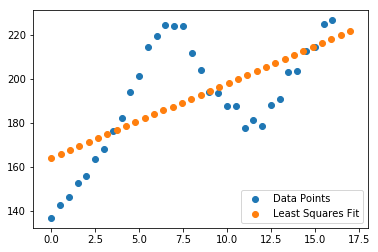

In [124]:
fig, ax = plt.subplots()
ax.scatter(housing[:, 0], housing[:, 1], label='Data Points')
x_int = np.linspace(0, 17, 33)
ax.scatter(x_int, x[0] * x_int + x[1], label='Least Squares Fit')
plt.legend()
plt.show()

#### Problem 3

In [125]:
housing = np.load('housing.npy')

In [126]:
def housing_fit(housing):
    A = np.vander(housing[:, 0], 13)
    b = housing[:, 1]
    x_int = np.linspace(0, 17, 1000)
    fig, axes = plt.subplots(4, 1, figsize=(8, 20))
    
    for n, i in enumerate(range(9, -1, -3)):
        A_i = A[:, i:]
        x = la.lstsq(A_i, b)[0]
        f = np.poly1d(x)
        axes[n,].scatter(housing[:, 0], housing[:, 1], label='Data Points')
        axes[n,].plot(x_int, f(x_int), color='orange', label=f'Polynomial degree {12 - i} fit')
        axes[n,].legend(loc='lower center')
        axes[n,].set_ylim([110, 240])
        
    plt.show()    

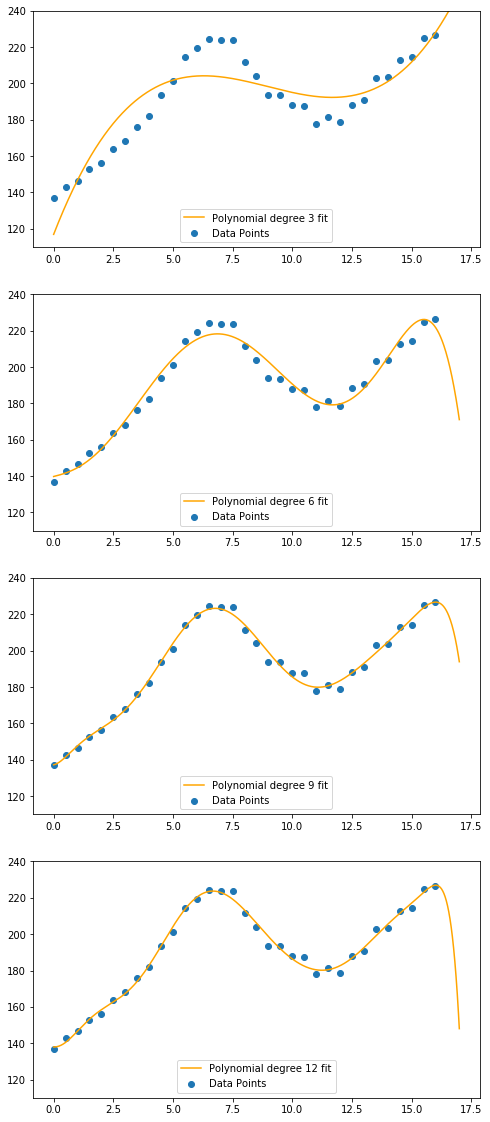

In [127]:
housing_fit(housing)

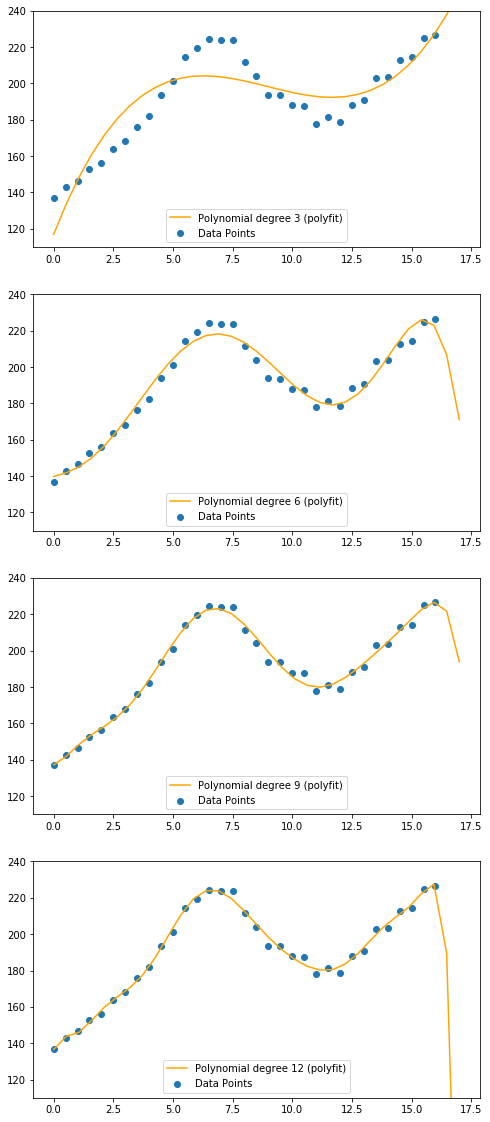

In [128]:
fig, axes = plt.subplots(4, 1, figsize=(8, 20))

for n, i in enumerate(range(3, 13, 3)):
    
    f = np.poly1d(np.polyfit(housing[:, 0], housing[:, 1], i))
    axes[n,].scatter(housing[:, 0], housing[:, 1], label='Data Points')
    axes[n,].plot(x_int, f(x_int), color='orange', label=f'Polynomial degree {i} (polyfit)')
    axes[n,].legend(loc='lower center')
    axes[n,].set_ylim([110, 240])

#### Problem 4

In [129]:
ellipse = np.load('ellipse.npy')

In [130]:
def ellipse_fit(ellipse):
    x, y = ellipse[:, 0], ellipse[:, 1]
    A = np.column_stack((x ** 2, x, x * y, y, y ** 2))
    b_vec = np.ones(len(ellipse))
    
    c = la.lstsq(A, b_vec)[0]
    plot_ellipse(c[0], c[1], c[2], c[3], c[4])
    plt.scatter(x, y, label='Data Points')
    plt.show()
    

In [131]:
def plot_ellipse(a, b, c, d, e):
    theta = np.linspace(0, 2 * np.pi, 200)
    cos_t, sin_t = np.cos(theta), np.sin(theta)
    A = a * (cos_t ** 2) + c * cos_t * sin_t + e * (sin_t ** 2)
    B = b * cos_t + d * sin_t
    r = (-B + np.sqrt(B ** 2 + 4 * A)) / (2 * A)
    plt.plot(r * cos_t, r * sin_t, lw=2, color='orange', label='Fitted Ellipse')
    plt.gca().set_aspect('equal', 'datalim')

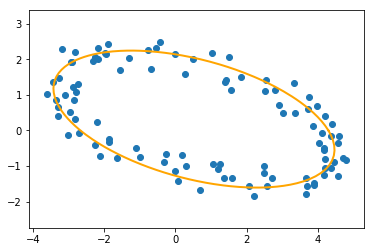

In [132]:
ellipse_fit(ellipse)

#### Problem 5

In [133]:
def power_method(A, N, tol):
    m, n = A.shape
    x = np.random.random(size=n)
    x = x / la.norm(x)
    k = 0
    t = 1e8
    while (t > tol) & (k < N):
        x = A @ x
        x = x / la.norm(x)
        k += 1
    return x.T @ A @ x, x

In [134]:
A = np.random.random((10, 10))
eigs, vecs = la.eig(A)
loc = np.argmax(eigs)
lamb, x = eigs[loc], vecs[:, loc]

In [135]:
np.allclose(A @ x, lamb * x)

True

In [136]:
lamb, x = power_method(A, 100, 1e-4)

In [137]:
np.allclose(A @ x, lamb * x)

True

#### Problem 6

In [138]:
def QR_algorithm(A, N, tol):
    m, n = A.shape
    S = la.hessenberg(A)
    for k in range(N):
        Q, R = QR_decomposition(S)
        S = R @ Q
    eigs = []
    i = 0
    while i < n:
        if i == n - 1:
            eigs.append(S[i, i])
        elif S[i + 1, i] < tol:
            eigs.append(S[i, i])
        elif len(S[i:, i:]) == 2:
            λ1 = ((S[i, i] + S[i+1, i+1]) + cmath.sqrt((S[i, i] + S[i+1, i+1]) ** 2 
                                                      - 4 * (S[i, i] * S[i+1, i+1] - S[i, i+1] * S[i+1, i]))) / 2
            λ2 = ((S[i, i] + S[i+1, i+1]) - cmath.sqrt((S[i, i] + S[i+1, i+1]) ** 2 
                                                      - 4 * (S[i, i] * S[i+1, i+1] - S[i, i+1] * S[i+1, i]))) / 2
            eigs.append(λ1, λ2)
            i += 1
        i += 1
        
    return eigs

In [139]:
A = np.random.random((5, 5))
la.eig(A + A.T)

(array([ 5.95043274+0.j, -0.74961443+0.j, -0.34544329+0.j,  0.18027506+0.j,
         0.37522086+0.j]),
 array([[ 0.34524717,  0.30410358, -0.64397556,  0.58131852,  0.18891706],
        [ 0.36149811, -0.80245421, -0.39371922, -0.16306699, -0.20923836],
        [ 0.45506746, -0.17244211,  0.62899048,  0.5770973 , -0.18576061],
        [ 0.53129931,  0.48340248, -0.02910066, -0.42086953, -0.55323149],
        [ 0.51064485,  0.01319149,  0.18386076, -0.35398513,  0.76154945]]))

In [140]:
print(A)

[[0.28549852 0.12909773 0.53037007 0.58274245 0.23228641]
 [0.67697439 0.13128938 0.75039371 0.81633773 0.48038664]
 [0.63105067 0.20792584 0.57314116 0.98549827 0.30948089]
 [0.30875053 0.66915494 0.51676499 0.82549767 0.73306012]
 [0.8715473  0.60160419 0.94511551 0.74716387 0.89000873]]


In [141]:
QR_algorithm(A + A.T, 1000, 1e-8)

[5.950432736293826,
 -0.7496144345338698,
 0.375220862605631,
 -0.34544328516908723,
 0.1802750553126464]

# The SVD and Image Compression

In [142]:
import numpy as np
from scipy import linalg as la
import cmath
from matplotlib import pyplot as plt

In [143]:
def compact_SVD(A, tol):
    λ, V = la.eig(A.conj().T @ A)
    σ = np.sqrt(λ).real
    order = np.argsort(σ)[::-1]
    σ[order]
    V[order]
    r = np.sum(σ > tol)
    σ = σ[:r]
    V = V[:, :r]
    U = A @ V / σ
    return U, σ, V.conj().T

In [144]:
A = np.random.random((10, 5))
U, σ, V_H = la.svd(A, full_matrices=False)
print(U.shape, σ.shape, V_H.shape)

(10, 5) (5,) (5, 5)


In [145]:
np.allclose(U.T @ U, np.identity(5))

True

In [146]:
np.allclose(U @ np.diag(σ) @ V_H, A)

True

In [147]:
np.linalg.matrix_rank(A) == len(σ)

True

In [148]:
U, σ, V_H = compact_SVD(A, 1e-8)

In [149]:
np.allclose(U.T @ U, np.identity(5))

True

In [150]:
np.allclose(U @ np.diag(σ) @ V_H, A)

True

In [151]:
np.linalg.matrix_rank(A) == len(σ)

True

#### Problem 2

In [152]:
def unit_circle(A):
    θ = np.linspace(0, 2 * np.pi, 200)
    S = np.vstack((np.cos(θ), np.sin(θ)))
    E = np.array([[1, 0, 0], [0, 0, 1]])
    
    U, σ, V_H = la.svd(A)
    Σ = np.diag(σ)
    
    fig, axes = plt.subplots(2, 2)
    axes[0, 0].plot(S[0], S[1])
    axes[0, 0].plot(E[0], E[1]) 
    axes[0, 0].axis('equal')
    
    axes[0, 1].plot((V_H @ S)[0], (V_H @ S)[1])
    axes[0, 1].plot((V_H @ E)[0], (V_H @ E)[1])
    axes[0, 1].axis('equal')
    
    axes[1, 0].plot((Σ @ V_H @ S)[0], (Σ @ V_H @ S)[1])
    axes[1, 0].plot((Σ @ V_H @ E)[0], (Σ @ V_H @ E)[1])
    axes[1, 0].axis('equal')
    
    axes[1, 1].plot((U @ Σ @ V_H @ S)[0], (U @ Σ @ V_H @ S)[1])
    axes[1, 1].plot((U @ Σ @ V_H @ E)[0], (U @ Σ @ V_H @ E)[1])
    axes[1, 1].axis('equal')
    
    plt.show()

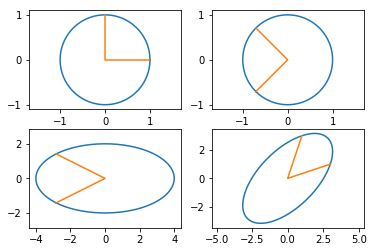

In [153]:
A = np.array([[3, 1], [1, 3]])
unit_circle(A)

#### Problem 3

In [154]:
def truncated_SVD(A, s):
    U, σ, V_H = la.svd(A)
    if s > len(σ):
        raise ValueError('s cannot be greater than rank(A)')
    σ = σ[:s]
    U = U[:, :s]
    V_H = V_H[:s, :]
    Σ = np.diag(σ)
    
    return U @ Σ @ V_H, U.size + σ.size + V_H.size

In [155]:
A = np.random.random((5, 5))
As, entries = truncated_SVD(A, 3)

In [156]:
np.linalg.matrix_rank(As)

3

In [157]:
entries

33

#### Problem 4

In [158]:
def truncated_SVD_error(A, ϵ):
    U, σ, V_H = la.svd(A)
    if ϵ < np.min(σ):
        raise ValueError('ϵ must be larger than the smallest singular value of A')
    s = len(σ[σ > ϵ])
    σ = σ[:s]
    U = U[:, :s]
    V_H = V_H[:s, :]
    Σ = np.diag(σ)
    
    return U @ Σ @ V_H, U.size + σ.size + V_H.size

In [159]:
A = np.random.random((3, 3))
As, entries = truncated_SVD_error(A, 0.5)
la.norm(A - As)

0.11287511668771921

In [160]:
A = np.random.random((10, 10))
As, entries = truncated_SVD_error(A, 0.2)
la.norm(A - As)

0.11082594123383713

#### Problem 5

In [161]:
def image_compression(filename, s):
    image = plt.imread(filename) / 255
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    if image.ndim == 2:
        axes[0].imshow(image, cmap='gray')
        axes[0].axis('off')

        im_approx, entries = truncated_SVD(image, s)
        im_approx[im_approx < 0] = 0
        im_approx[im_approx > 1] = 1
        axes[1].imshow(im_approx, cmap='gray')
        axes[1].axis('off')
        
        plt.suptitle(f'Difference in number of entries required: {image.size - entries}', fontsize=20)
        plt.show()
    
    elif image.ndim == 3:
        axes[0].imshow(image)
        axes[0].axis('off')

        layers = []
        entries = 0
        for i in range(3):
            color = image[:,:,i]
            layer, entries_i = truncated_SVD(color, s)
            layer[layer < 0] = 0
            layer[layer > 1] = 1
            layers.append(layer)
            entries += entries_i
        approximated = np.dstack(layers)
        axes[1].imshow(approximated)
        axes[1].axis('off')
             
        plt.suptitle(f'Difference in number of entries required: {image.size - entries}', fontsize=20)
        plt.show()

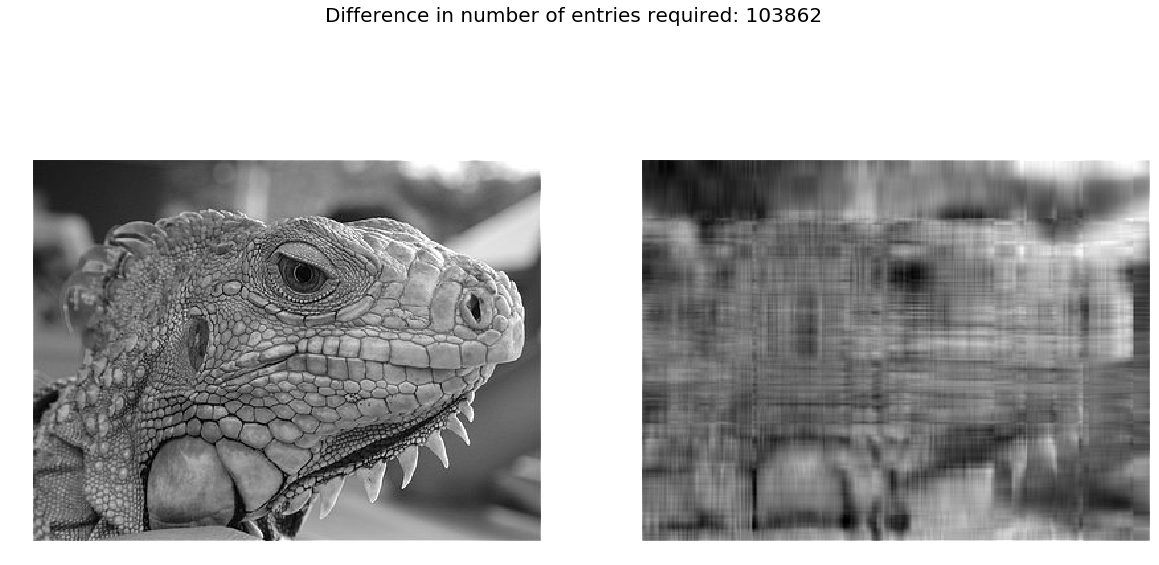

In [162]:
image_compression('grey.jpg', 10)

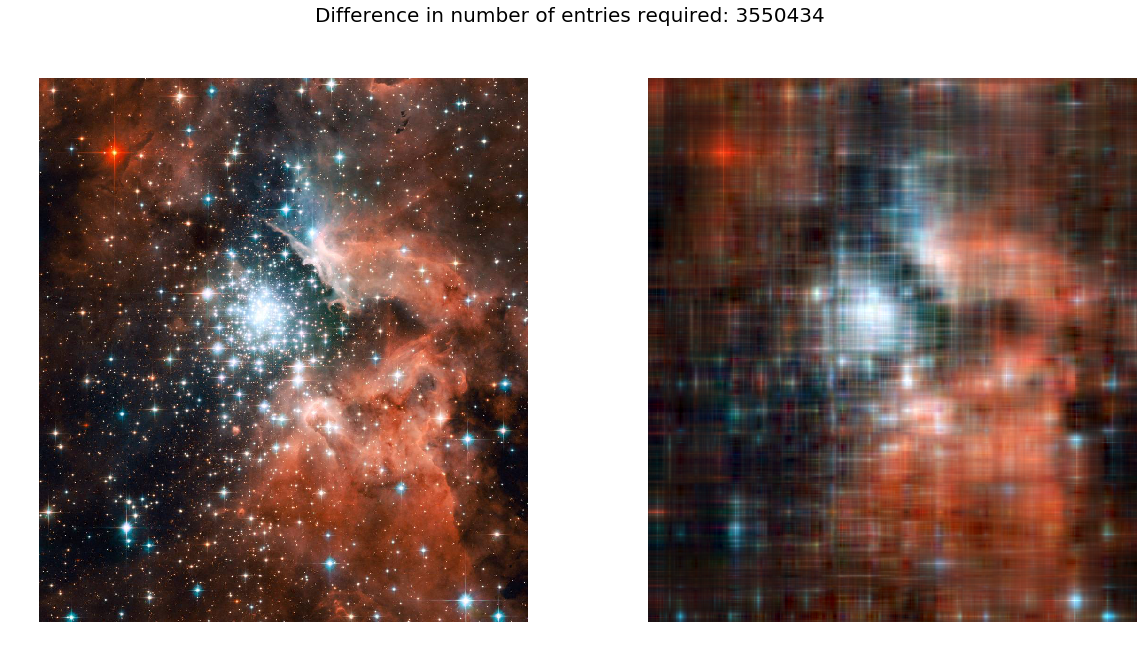

In [163]:
image_compression('hubble.jpg', 10)

# The Drazin Inverse

In [164]:
import numpy as np
from scipy import linalg as la
import pandas as pd

#### Problem 1

In [165]:
def is_drazin(A, k, A_D):
    return (np.allclose(A @ A_D, A_D @ A) 
            & np.allclose(np.linalg.matrix_power(A, k+1) @ A_D, np.linalg.matrix_power(A, k)) 
            & np.allclose(A_D @ A @ A_D, A_D))

In [166]:
A = np.array([[1, 3, 0, 0], [0, 1, 3, 0], [0, 0, 1, 3], [0, 0, 0, 0]])
A_D = np.array([[1, -3, 9, 81], [0, 1, -3, -18], [0, 0, 1, 3], [0, 0, 0, 0]])
is_drazin(A, 1, A_D)

True

In [167]:
B = np.array([[1, 1, 3], [5, 2, 6], [-2, -1, -3]])
B_D = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])
is_drazin(B, 3, B_D)

True

#### Problem 2

In [168]:
def drazin(A, tol):
    n, n = A.shape
    f = lambda x: abs(x) > tol
    g = lambda x: abs(x) <= tol
    Q1, S, k1 = la.schur(A, sort=f)
    Q2, T, k2 = la.schur(A, sort=g)
    U = np.hstack((S[:, :k1], T[:, :(n - k1)]))
    U_inv = la.inv(U)
    V = U_inv @ A @ U
    Z = np.zeros((n, n))
    if k1 != 0:
        M_inv = la.inv(V[:k1, :k1])
        Z[:k1, :k1] = M_inv
    return U @ Z @ U_inv

In [169]:
drazin(A, 1e-3)

array([[  1.,  -3.,   9.,  81.],
       [  0.,   1.,  -3., -18.],
       [  0.,   0.,   1.,   3.],
       [  0.,   0.,   0.,   0.]])

In [170]:
drazin(B, 1e-3)

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

#### Problem 3

In [171]:
def find_resistance(G):
    n, n = G.shape
    L = np.sum(G, axis=0) * np.identity(n) - G
    R = np.empty_like(L)
    
    for j in range(n):
        Lj = L.copy()
        Lj[:, j] = np.identity(n)[:, j]
        Lj_D = drazin(Lj, 1e-3)
        R[:, j] = Lj_D.diagonal()
    
    for i in range(len(R)):
         R[i, i] = 0
            
    return R

In [172]:
G1 = np.array([[0, 1, 0, 0], [1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0]])
find_resistance(G1)

array([[0., 1., 2., 3.],
       [1., 0., 1., 2.],
       [2., 1., 0., 1.],
       [3., 2., 1., 0.]])

In [173]:
G2 = np.array([[0, 1], [1, 0]])
find_resistance(G2)

array([[0., 1.],
       [1., 0.]])

In [174]:
G3 = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])
find_resistance(G3)

array([[0.        , 0.66666667, 0.66666667],
       [0.66666667, 0.        , 0.66666667],
       [0.66666667, 0.66666667, 0.        ]])

In [175]:
G4 = np.array([[0, 3], [3, 0]])
find_resistance(G4)

array([[0.        , 0.33333333],
       [0.33333333, 0.        ]])

In [176]:
G5 = np.array([[0, 2], [2, 0]])
find_resistance(G5)

array([[0. , 0.5],
       [0.5, 0. ]])

In [177]:
G6 = np.array([[0, 4], [4, 0]])
find_resistance(G6)

array([[0.  , 0.25],
       [0.25, 0.  ]])

#### Problem 4 + 5

In [178]:
class LinkPredictor:
    
    def __init__(self, file):
        network = pd.read_csv(file, header=None)
        self.names = np.unique(np.concatenate((network[0], network[1]))) #list of unique names
        n = len(self.names)
        self.adjacency = np.zeros((n, n), dtype=int)
        for i in network.index:   #iterate through pairs of names
            link = network.loc[i]
            name1, name2 = link[0], link[1]
            i = np.argwhere(self.names == name1)
            j = np.argwhere(self.names == name2)
            self.adjacency[i, j], self.adjacency[j, i] = 1, 1  #add link
        self.resistance = find_resistance(self.adjacency)  #calculate resistance matrix
        
    def predict_link(self, node=None):
        r = self.resistance.copy()
        connected = np.argwhere(self.adjacency == 1)  #locate pairs of connected people
        r[connected[:, 0], connected[:, 1]] = 0  #set resistance between these pairs to 0
        if node is None:
            min_val = np.min(r[r > 0])  #find least (nonzero) resistance
            loc = np.argwhere(r == min_val).flatten()
            pair = (self.names[loc[0]], self.names[loc[1]])
        elif type(node) == str:
            if node not in self.names:
                raise ValueError('Not in network')
            index = np.argwhere(self.names == node).flatten()[0]
            min_val = np.min(r[index][r[index] > 0])  #find least (nonzero) resistance for in indexed row
            loc = np.argwhere(r[index] == min_val).flatten()
            pair = (self.names[index], self.names[loc[0]])
        else:
            raise ValueError('Incorrect type')
        return pair
    
    def add_link(self, node1, node2):
        if (node1 not in self.names) or (node1 not in self.names):
            raise ValueError("Not in network")
        else:
            i = np.argwhere(self.names == node1)
            j = np.argwhere(self.names == node2)
            self.adjacency[i, j], self.adjacency[j, i] = 1, 1
            self.resistance = find_resistance(self.adjacency)

In [179]:
link = LinkPredictor('social_network.csv')

In [180]:
link.predict_link()

('Emily', 'Oliver')

In [181]:
link.predict_link('Melanie')

('Melanie', 'Carol')

In [182]:
link.predict_link('Alan')

('Alan', 'Sonia')

In [183]:
link.add_link('Alan', 'Sonia')
link.predict_link('Alan')

('Alan', 'Piers')

In [184]:
link.add_link('Alan', 'Piers')
link.predict_link('Alan')

('Alan', 'Abigail')

# The PageRank Algorithm

In [185]:
import numpy as np
from scipy import sparse

#### Problem 1

In [186]:
def adjacency_matrix(filename, N):
    edge_list = []
    with open(filename, 'r') as file:
        for line in file:
            try:
                edge_list.append(list(map(int, line.strip().split())))
            except:
                pass
    matrix = np.zeros((N, N), dtype=int)
    for x, y in edge_list:
        matrix[x, y] = 1
    return sparse.dok_matrix(matrix)

In [187]:
adjacency_matrix('matrix.txt', 8)

<8x8 sparse matrix of type '<class 'numpy.int64'>'
	with 12 stored elements in Dictionary Of Keys format>

#### Problem 2